[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20Outlier.ipynb)

# If working in colab, clone the repo

In [1]:
import os
import sys

try:
    __import__('google.colab')
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    os.system('rm -rf /content/hasoc_code/')
    os.system('git clone --recurse-submodules https://github.com/cozek/hasoc_code')
    sys.path.append('/content/hasoc_code/src')
else:
    sys.path.append('../../src')

# Import libraries

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter

In [5]:
import utils.general as general_utils
import utils.data as data_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

# Set up the argspace/important_variables

In [6]:
args = Namespace()

In [7]:
if not IN_COLAB:
    _prefix = '../../'
else : #for colab
    _prefix = '/content/hasoc_code/'
    #location of the train, dev and test csv
args.data_tsv = _prefix + 'data/english_dataset/english_dataset.tsv'
args.test_tsv = _prefix + 'data/english_dataset/hasoc2019_en_test-2919.tsv'

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [8]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

In [9]:
task_a_label_dict = {'NOT' :0, 'HOF': 1}

In [10]:
hasoc_data_df_task_a.label = hasoc_data_df_task_a.label.map(task_a_label_dict)

### Train set Samples

In [11]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,0
2876,#GandiNaaliAbuse | Where an MP says that he wi...,1
2996,"Candle light silent protest in MYSORE, by Myso...",0
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
1074,#ICC ...look at pak team...wht is going on.......,0


0    3591
1    2261
Name: label, dtype: int64


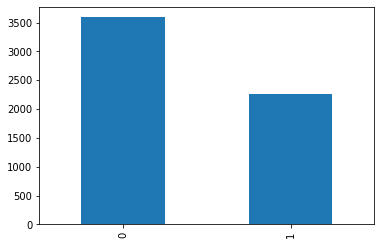

In [12]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [13]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

In [14]:
print(data_df.split.value_counts())
sum(data_df.label.value_counts()) == \
sum(data_df[data_df.split == 'train'].label.value_counts())\
 + sum(data_df[data_df.split == 'val'].label.value_counts())

train    5267
val       585
Name: split, dtype: int64


True

In [15]:
hasoc_data_df_task_a.label.value_counts()

0    3591
1    2261
Name: label, dtype: int64

### One-Class Classification using SVM

In [16]:
from sklearn.svm import OneClassSVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import sklearn.metrics
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Training OneClass SVM for each class

In [17]:
ngram_max = 50 #max n that we check

fig = make_subplots(
    rows=len(task_a_label_dict.keys()), cols=1,
    subplot_titles= [f'Class : {l}' for l in task_a_label_dict.keys()],
    shared_yaxes=True,
    x_title='ngram size',
    y_title='Train Accuracy',
)
lbl_accs = {}
for i,lbl in enumerate(task_a_label_dict.keys(), start = 1):
    ngram_acc = {}
    
    #Get the samples with the corresponding label from the DF
    hate_text_df =\
        data_df[ (data_df.split == 'train') & (data_df.label == task_a_label_dict[lbl]) ]
    
    #check the n in ngram 
    for n in notebook.tqdm(range(1,ngram_max+1), total = ngram_max):
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(n,n))
        hate_tfidf = tfidf_vectorizer.fit_transform(hate_text_df.text)
        clf = OneClassSVM(gamma='auto').fit(hate_tfidf)
        preds = clf.predict(hate_tfidf)
        acc = sklearn.metrics.accuracy_score(
            y_true = [1 for i in range(len(hate_text_df))],
            y_pred = preds, 
        )
        ngram_acc[n] = acc
    lbl_accs[lbl] = ngram_acc
    subfig = go.Scatter(
        x = list(ngram_acc.keys()),
        y = list(ngram_acc.values()),
        mode = "lines+markers",
        name=lbl,
    )

    fig.append_trace(subfig, row = i, col=1)


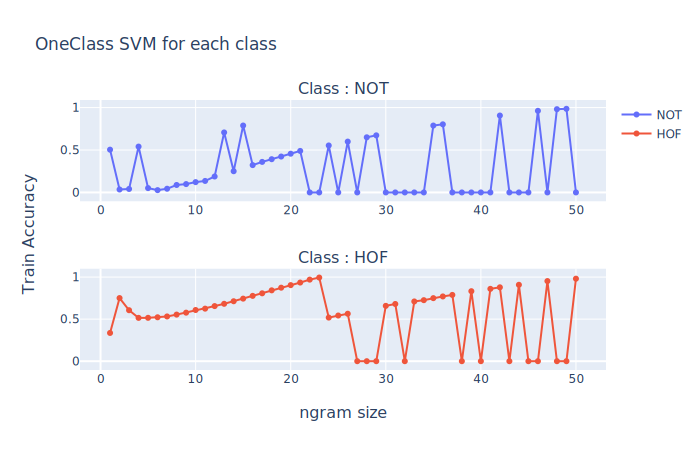

Class NOT -> Best Acc: 0.9854579207920792 with n: 49
Class HOF -> Best Acc: 0.9941031941031941 with n: 23


In [19]:
fig.update_layout(
    title = "OneClass SVM for each class",
)
fig.show(renderer='svg')

for key,val in lbl_accs.items():
    best_n = max(list(val.items()), key = lambda x: x[1])    
    print(f'Class {key} -> Best Acc: {best_n[1]} with n: {best_n[0]}')